## Analysis

You will need to install both `networkx` (using `pip`) and `matplotlib` (see <http://matplotlib.org/users/installing.html> for installation instructions)

In [1]:
import networkx as nx
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import matplotlib.pyplot as plt
from rdflib import ConjunctiveGraph
import operator
from pprint import pprint
import numpy as np
%matplotlib inline  

In [2]:
prefix = "PREFIX : <http://data.krw.d2s.labs.vu.nl/group6/vocab/>"
TUTORIAL_REPOSITORY = "http://stardog.krw.d2s.labs.vu.nl/group6"
endpoint = TUTORIAL_REPOSITORY + "/query"

In [3]:
def clearStardog():
    """Careful! This one clears the entire stardog repository specified in TUTORIAL_REPOSITORY"""
    transaction_begin_url = TUTORIAL_REPOSITORY + "/transaction/begin"
    
    # Start the transaction, and get a transaction_id
    response = requests.post(transaction_begin_url, headers={'Accept': 'text/plain'})
    transaction_id = response.content

    print "Transaction id: {}".format(transaction_id)
    # POST the data to the transaction
    post_url = TUTORIAL_REPOSITORY + "/" + transaction_id + "/clear"
    response = requests.post(post_url, headers={'Accept': 'text/plain'})
    
    print "Sent clear request: {}".format(response.status_code)
    
    # Close the transaction
    transaction_close_url = TUTORIAL_REPOSITORY + "/transaction/commit/" + transaction_id
    response = requests.post(transaction_close_url)

    print "Closing transaction: {}".format(response.status_code)
    
    return

def upload_file_to_stardog(filename, mimetype='application/trig'):
    """Well, obvious what this does... you can set the 'mimetype' to e.g. text/turtle if you want to upload a turtle file"""
    with open(filename,'r') as f:
        data = f.read()
        
    upload_to_stardog(data, mimetype=mimetype)
    
    return
    

def upload_to_stardog(data, mimetype='application/trig'):
    """Upload data to Stardog, you know this one from the previous assignments..."""
    transaction_begin_url = TUTORIAL_REPOSITORY + "/transaction/begin"
    
    # Start the transaction, and get a transaction_id
    response = requests.post(transaction_begin_url, headers={'Accept': 'text/plain'})
    transaction_id = response.content

    print "Transaction id: {}".format(transaction_id)
    
    # POST the data to the transaction
    post_url = TUTORIAL_REPOSITORY + "/" + transaction_id + "/add"
    response = requests.post(post_url, data=data, headers={'Accept': 'text/plain', 'Content-type': mimetype}, stream=True)

    print "Sent add request: {}".format(response.status_code)
    
    # Close the transaction
    transaction_close_url = TUTORIAL_REPOSITORY + "/transaction/commit/" + transaction_id
    response = requests.post(transaction_close_url)

    print "Closing transaction: {}".format(response.status_code)
    
    return

    
def getClasses(reasoning='true', max=None):
    """Get all classes from the repo, optionally with a limit of `max`"""
    if max is None :
        query = prefix + """SELECT ?c WHERE {?c a owl:Class }"""
    else :
        query = prefix + """SELECT ?c WHERE {?c a owl:Class } LIMIT """ + str(max)
    
    return [r['c']['value'] for r in runQuery(query, reasoning)]
    

def getInstances(className, reasoning='true'):
    """Get the instances for a class.. be sure to include < and > around its URI"""
    query = prefix + """
    SELECT ?i WHERE {{?i a {} . }}
    """.format(className)
    
    return [r['i']['value'] for r in runQuery(query, reasoning)]

def countUsage(reasoning='true', max=None):
    """Count the number of occurrences of a resource. Will differ significantly if reasoning is 'false'"""
    query = """
        SELECT ?resource (COUNT(?resource) as ?count) WHERE {
            { ?resource ?p1 ?o1 . }
            UNION
            { ?s1 ?resource ?o2 . }
            UNION
            { ?s2 ?p2 ?resource . }
        } GROUP BY ?resource ORDER BY DESC(?count)
    """
    
    results = runQuery(query, reasoning)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        if 'resource' in r:
            index[unicode(r['resource']['value'])] = int(r['count']['value'])
        
        count += 1
    
    return index


def countClassUsage(reasoning='true', max=None):
    """Count how many (inferred) instances a class has"""
    query = """
        SELECT ?class (COUNT(?resource) as ?count) WHERE {
            ?resource a ?class . 
        } GROUP BY ?class ORDER BY DESC(?count)
    """
    
    results = runQuery(query, reasoning)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        if 'class' in r:
            index[unicode(r['class']['value'])] = int(r['count']['value'])
        
        count += 1
    
    return index

def countUsageLocal(rdfgraph, max=None):
    """Count usage of a resource on a local RDFLib graph"""
    query = """
        SELECT ?resource (COUNT(?resource) as ?count) WHERE {
            { ?resource ?p1 ?o1 . }
            UNION
            { ?s1 ?resource ?o2 . }
            UNION
            { ?s2 ?p2 ?resource . }
        } GROUP BY ?resource ORDER BY ?resource
    """
    
    results = g.query(query)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
            
        index[unicode(r['resource'])] = int(r['count'])
        
        count += 1
    
    return index
    

def runQuery(query, reasoning='true'):
    """Run a SPARQL query against the endpoint"""
    sparql = SPARQLWrapper(endpoint)

    sparql.setQuery(query)

    sparql.setReturnFormat(JSON)
    sparql.addParameter('Accept','application/sparql-results+json')

    sparql.addParameter('reasoning',reasoning)

    response = sparql.query().convert()

    return response['results']['bindings']

### Example analysis

Upload the example files to Stardog

In [4]:
#upload_file_to_stardog('o1.trig')
#upload_file_to_stardog('o2.trig')
#upload_file_to_stardog('d1.trig')
#upload_file_to_stardog('d2.trig')

Now get all classes from the repository. Select one, and use its URI to retrieve instances.

(Play around with reasoning 'false' and 'true')

In [5]:
for c in getClasses(max=1000, reasoning='true'): print c

http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Theatre
http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/SmallSlot
http://rdfs.org/ns/void#Dataset
http://dbpedia.org/ontology/Country
http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Event
http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Exhibition
http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/LargeSlot
http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Museum
http://www.w3.org/2002/07/owl#Nothing
http://rdfs.org/ns/void#Linkset
http://dbpedia.org/ontology/Location
http://dbpedia.org/ontology/Place
http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Play
http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Venue
http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Location
http://dbpedia.org/ontology/City
http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/ParkingSlot
http://www.w3.org/2002/07/owl#Thing
http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/MediumSlot
http://data.krw.d2s.labs.vu.nl/gr

In [6]:
for i in getInstances('<http://www.w3.org/2002/07/owl#Thing>', reasoning='true'): print i

http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Amstelveens_Poppentheater
http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Amsterdams_Marionetten_Theater
http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Apollofirst_Theater
http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Badhuistheater
http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Betty_Asfalt_Complex
http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Bijlmer_Parktheater
http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Boekhandel_Scheltema
http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Boekwinkel_Casperle
http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Boom_Chicago
http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Buurtcentrum_De_Havelaar
http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Club_The_Winston_Kingdom
http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Comedy_Café
http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Compagniet

### Locally

Load the example files in an RDFLib graph (locally). Note that a large graph may become problematic (given memory limitations).

A `ConjunctiveGraph` object allows for loading named graphs, but hides them (i.e. you don't need to think about the graphs when querying the data).

In [7]:
from os.path import join
g = ConjunctiveGraph()

for f in map(lambda f: join('../data', f), ['museums.trig', 'parking_slots.trig', 'theaters.trig']):
    g += g.parse(f, format='trig')

Several simple statistics. The following code uses the `index` variable. Adjust where needed (e.g. replace `index` with `index_remote`)

In [8]:
index = countUsageLocal(g)
sorted_index = sorted(index.items(), key=operator.itemgetter(1), reverse=True)
for i, item in enumerate(sorted_index):
    print '%-3i %-100s %-12i' % (i+1, item[0][:100], item[1])

1   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/calendar_summary                               2760        
2   http://www.w3.org/1999/02/22-rdf-syntax-ns#type                                                      1855        
3   http://www.w3.org/2000/01/rdf-schema#label                                                           1767        
4   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/single_date                                    1604        
5   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/short_description                              984         
6   http://www.w3.org/2003/01/geo/wgs84_pos#lat                                                          691         
7   http://www.w3.org/2003/01/geo/wgs84_pos#long                                                         691         
8   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Location                                       681         
9   http://dbpedia.org/resource/Kingdom_of_the_Netherlan

In [9]:
index_remote = countUsage(reasoning='false')
sorted_index_remote = sorted(index_remote.items(), key=operator.itemgetter(1), reverse=True)
for i, item in enumerate(sorted_index_remote):
    print '%-3i %-100s %-12i' % (i+1, item[0][:100], item[1])

1   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/calendar_summary                               2770        
2   http://www.w3.org/1999/02/22-rdf-syntax-ns#type                                                      2062        
3   http://www.w3.org/2000/01/rdf-schema#label                                                           1813        
4   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/single_date                                    1610        
5   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/short_description                              993         
6   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Location                                       699         
7   http://www.w3.org/2003/01/geo/wgs84_pos#long                                                         697         
8   http://www.w3.org/2003/01/geo/wgs84_pos#lat                                                          697         
9   http://dbpedia.org/ontology/city                    

In [10]:
index_classes = countClassUsage(reasoning='true')
sorted_index_classes = sorted(index_classes.items(), key=operator.itemgetter(1), reverse=True)
for i, item in enumerate(sorted_index_classes):
    print '%-3i %-100s %-12i' % (i+1, item[0][:100], item[1])

1   http://www.w3.org/2002/07/owl#Thing                                                                  1874        
2   http://dbpedia.org/ontology/Location                                                                 681         
3   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Location                                       681         
4   http://dbpedia.org/ontology/Place                                                                    681         
5   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/ParkingSlot                                    533         
6   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Event                                          479         
7   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Play                                           322         
8   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Venue                                          161         
9   http://data.krw.d2s.labs.vu.nl/group6/findaslot/voca

In [11]:
index_classes = countClassUsage(reasoning='false')
sorted_index_classes = sorted(index_classes.items(), key=operator.itemgetter(1), reverse=True)
for i, item in enumerate(sorted_index_classes):
    print '%-3i %-100s %-12i' % (i+1, item[0][:100], item[1])

1   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Location                                       684         
2   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/ParkingSlot                                    533         
3   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Event                                          477         
4   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Venue                                          160         
5   http://rdfs.org/ns/void#Dataset                                                                      67          
6   http://www.w3.org/1999/02/22-rdf-syntax-ns#List                                                      36          
7   http://www.w3.org/2002/07/owl#Class                                                                  27          
8   http://www.w3.org/2002/07/owl#Restriction                                                            24          
9   http://www.w3.org/2002/07/owl#DatatypeProperty      

Get the frequencies for each resource, and sort by frequency value.

Plot them at loglog scale

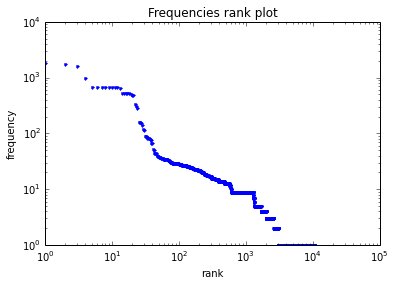

In [12]:
frequencies_by_value = sorted(index.values(), reverse=True)

plt.loglog(frequencies_by_value,'b-',linestyle='None', marker='.')
plt.title("Frequencies rank plot")
plt.ylabel("frequency")
plt.xlabel("rank")

Get the frequencies for each resource, and sort by URI name (i.e. alphabetically)

Plot them at loglog scale

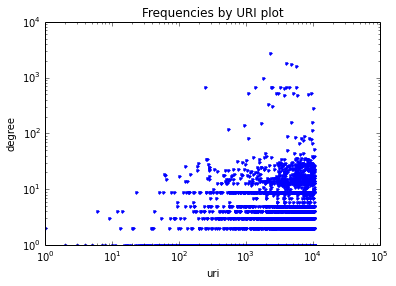

In [13]:
frequencies_by_URI = index.values()

plt.loglog(frequencies_by_URI,'b-',linestyle='None', marker='.')
plt.title("Frequencies by URI plot")
plt.ylabel("degree")
plt.xlabel("uri")

### Network Analysis

Build a directed `networkx` graph from the RDF graph

In [14]:
def buildNetwork(rdfgraph, query = """SELECT * WHERE {?source ?edge ?target.}""", max=None):
    ## Query is assumed to have a source, target and edge
    results = g.query(query)
    G = nx.DiGraph()
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        G.add_edge(r['source'], r['target'], {'type': r['edge']})
        count += 1
    return G

In [15]:
G = buildNetwork(g, max=10000)

Get the degrees for each node in the graph, and sort them from large to small

In [16]:
degree_sequence = sorted(nx.degree(G).values(),reverse=True) # degree sequence

# And see what it looks like...
for d in degree_sequence: print d

404
388
371
316
280
185
86
78
75
55
51
51
48
46
45
43
42
39
34
28
25
24
24
23
23
23
22
22
21
21
21
21
21
21
21
21
20
20
20
20
20
20
20
20
19
19
19
19
19
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9

Plot the graph using a spring layout (warning, may be very slow for large graphs)

/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


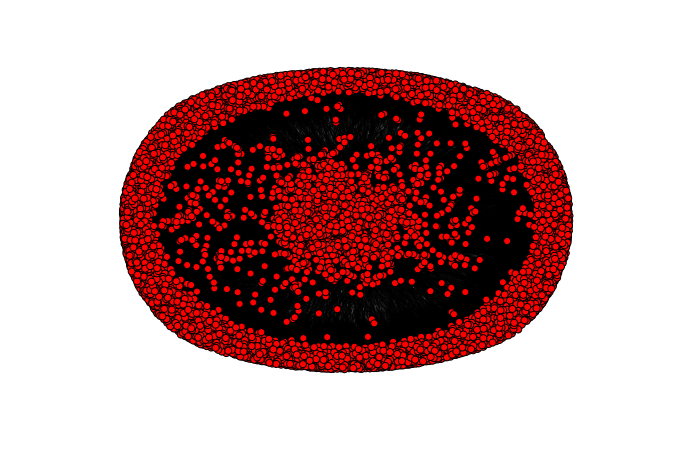

In [17]:
# draw graph in inset
plt.axes([1.45,1.45,1.45,1.45])
#Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]
pos=nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G,pos,node_size=50)
nx.draw_networkx_edges(G,pos,alpha=0.4)

# plt.savefig("graph.png")
plt.show()

Plot the degrees at loglog scale

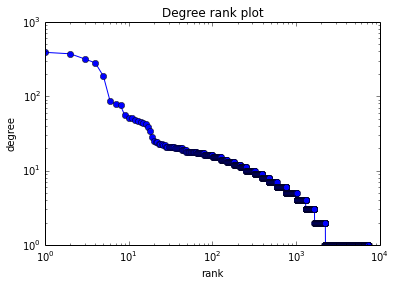

In [18]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

You can also do Pagerank on the graph (have a look at the `networkx` documentation)

In [19]:
pr = nx.pagerank(G)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse=True)
pr_array = np.array(map(lambda s: s[1], sorted_pr))
print 'mean: %.6f\tstd: %.6f\tmax: %.6f\tmin: %.6f\n' % \
    (pr_array.mean(), pr_array.std(), pr_array.max(), pr_array.min())

n = 30
print 'First %d ranked entities:' % n
for i in xrange(n):
    print '%-3i %-90s %-12.6f' % (i+1, sorted_pr[i][0], sorted_pr[i][1])

mean: 0.000139	std: 0.000285	max: 0.012057	min: 0.000113

First 30 ranked entities:
1   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/ParkingSlot                          0.012057    
2   http://dbpedia.org/resource/Kingdom_of_the_Netherlands                                     0.010549    
3   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Location                             0.010303    
4   http://dbpedia.org/resource/Amsterdam                                                      0.009713    
5   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Borough                              0.007786    
6   1                                                                                          0.006814    
7   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Venue                                0.003066    
8   http://data.krw.d2s.labs.vu.nl/group6/findaslot/vocab/Event                                0.002850    
9   2                                               